In [1]:
#| default_exp preprocessing.lesson16_second_part

# Lesson16 Second part
> Reproducing lesson 16 part2

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

In [3]:
#| export
from cv_tools.core import *


In [4]:
#| export
import matplotlib as mpl
import logging
import random
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from fastcore.all import *
logging.disable(logging.WARNING)

In [5]:
#| export
from datasets import load_dataset

In [6]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torcheval.metrics import MulticlassAccuracy

In [44]:
from fastai_course22p2.preprocessing.lesson16_after_lesson import *

In [8]:
#| export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [9]:
# Setting the precision of the print options for torch tensors to 2 decimal places, 
# the maximum line width to 140 characters, and disabling scientific notation.
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

# Enabling the use of constrained layout for matplotlib figures.
mpl.rcParams['figure.constrained_layout.use'] = True

In [10]:
@inplace
def transformi(b):
	b['image'] = [TF.to_tensor(o) for o in b['image']]


In [11]:
#| export
dsd = load_dataset('fashion_mnist')
def prep_data():
	tds = dsd.with_transform(transformi)
	dls = DataLoaders.from_dd(tds, batch_size=1024, num_workers=4)
	return dls


In [12]:
dls = prep_data()

In [13]:
#| export
def conv(ni, nf, ks=3, act=True):
	res = nn.Conv2d(ni, nf, ks, stride=2, padding=ks//2)
	if act: res = nn.Sequential(res, nn.ReLU())
	return res


In [14]:
#| export
def conv_layers():
	return [
		conv(1, 8, ks=5), # 14x14
		conv(8, 16), # 7x7
		conv(16, 32), # 4x4
		conv(32, 64), # 2x2
		conv(64, 10, act=False), # 1x1
		nn.Flatten()
	]

In [15]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [16]:
#| export
def fit(model, epochs=1):
	learn = Learner(
		model, dls, 
		loss_func=F.cross_entropy, 
		lr=0.6,
		cbs=cbs,
	)
	learn.fit(epochs)
	return learn


accuracy,loss,epoch,train
0.152,2.299,0,train
0.197,2.086,0,eval


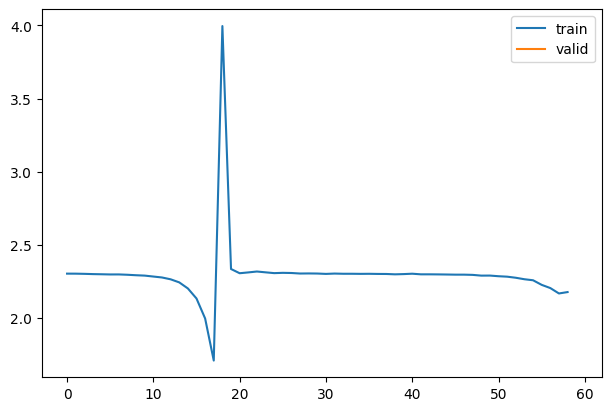

In [17]:
set_seed(1)
learn = fit(
    nn.Sequential(*conv_layers()),
    epochs=1
)

# Hooks

### Manual insertion

In [18]:
#| export
class SequentialModel(nn.Module):
	def __init__(self, *layers):
		super().__init__()
		self.layers = nn.ModuleList(layers)
		self.act_means = [[] for _ in self.layers]
		self.act_stds = [[] for _ in self.layers]

	def __call__(self, x):
		for i, layer in enumerate(self.layers):
			x = layer(x)
			self.act_means[i].append(to_cpu(x.mean()))
			self.act_stds[i].append(to_cpu(x.std()))
		return x

	def __iter__(self):
		return iter(self.layers)

	def __len__(self):
		return len(self.layers)


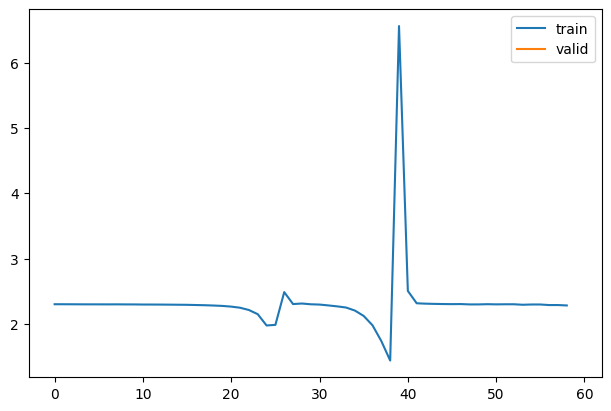

In [19]:
model = SequentialModel(*conv_layers())
learn = fit(model, epochs=1)

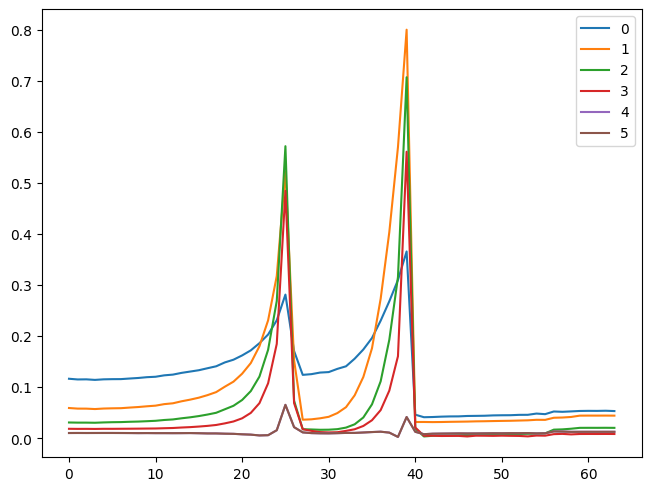

In [20]:
for l in model.act_means:
	plt.plot(l)
plt.legend(range(len(model.layers)))
plt.show()


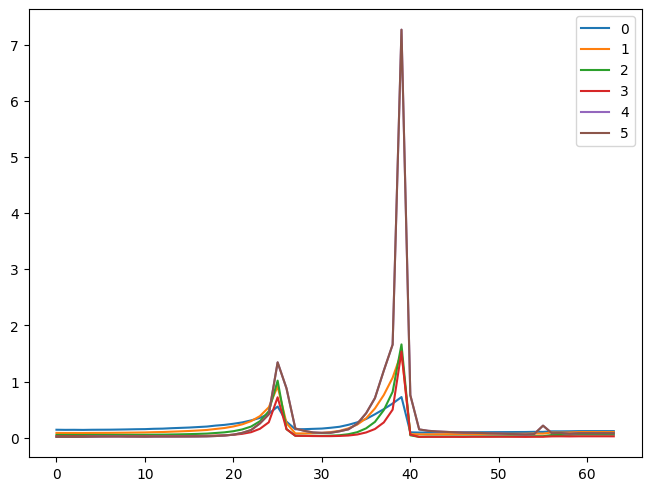

In [21]:
for l in model.act_stds:
	plt.plot(l)
plt.legend(range(len(model.layers)))
plt.show()

In [22]:
md = nn.Sequential(*conv_layers())

In [23]:
act_means = [[] for _ in md]
act_stds = [[] for _ in md]


In [24]:
#| export
def append_stats(i, mod, inp, out):
	act_means[i].append(to_cpu(out.mean()))
	act_stds[i].append(to_cpu(out.std()))


In [25]:
for i, layer in enumerate(md):
	layer.register_forward_hook(partial(append_stats, i))
	



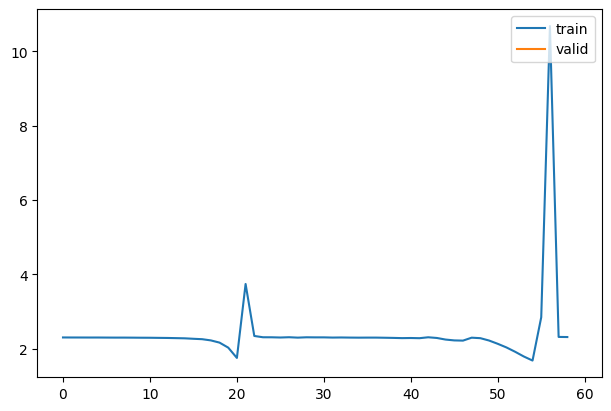

In [26]:
fit(md, epochs=1)

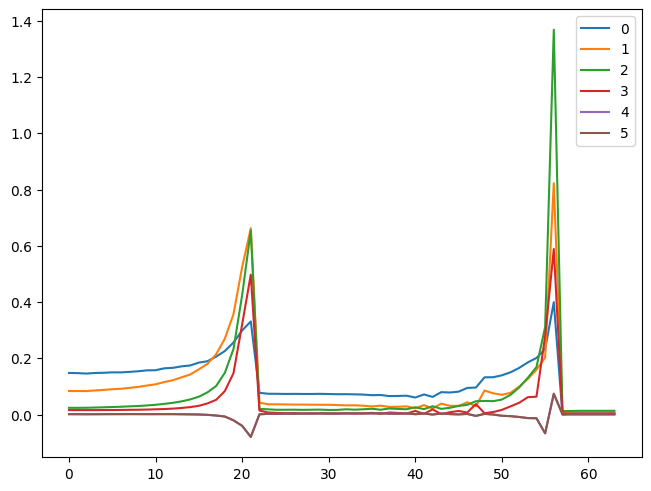

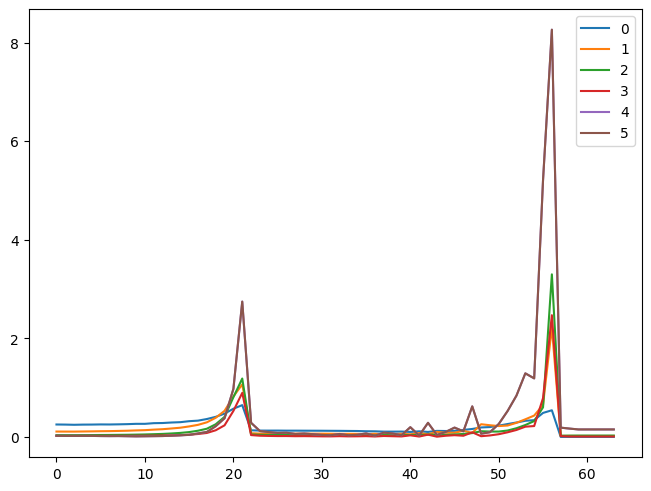

In [27]:
for l in act_means:
	plt.plot(l)
plt.legend(range(len(md)))
plt.show()

for l in act_stds:
	plt.plot(l)
plt.legend(range(len(md)))
plt.show()

In [28]:
#| export
class Hook():
	def __init__(self, module, func):
		self.hook = module.register_forward_hook(partial(func, self))

	def remove(self):
		self.hook.remove()

	def __del__(self):
		self.remove()


In [29]:
#| export
def append_stats(h, mod, inp, out):
	if not hasattr(h, 'stats'):h.stats = ([], [])
	act = to_cpu(out)
	h.stats[0].append(act.mean())
	h.stats[1].append(act.std())


In [30]:
md = nn.Sequential(*conv_layers())
hooks = [Hook(layer, append_stats) for i, layer in enumerate(md[:5].children())]


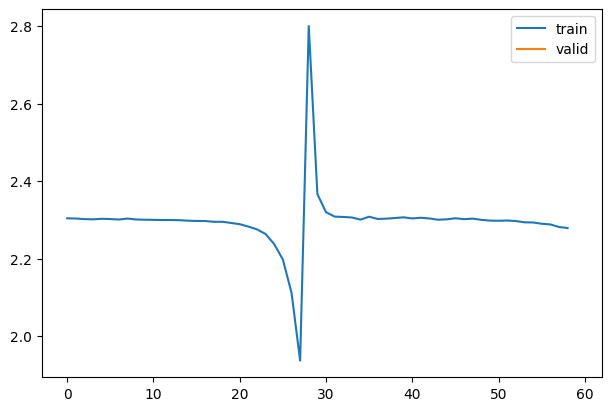

In [31]:
learn = fit(md, epochs=1)

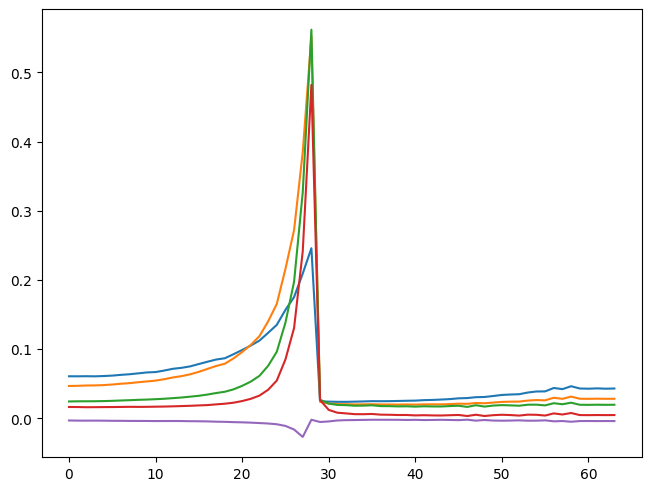

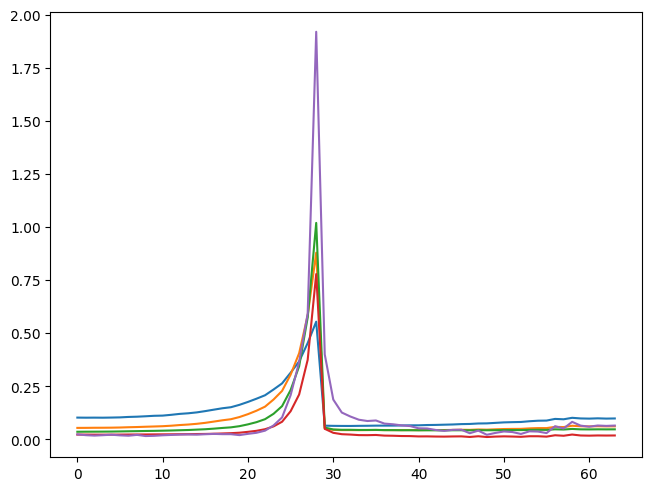

In [32]:
for h in hooks:
	plt.plot(h.stats[0])
	h.remove()
plt.show()

for h in hooks:
	plt.plot(h.stats[1])
	h.remove()
plt.show()


# Hooks

In [33]:
#| export
class Hooks(list):
	# Initialize the Hooks class by creating a list of Hook objects for each module in the input list 'ms'.
	# Each Hook is created with the module 'm' and the function 'append_stats'.
	def __init__(self, ms, f):
		super().__init__([Hook(m, f) for m in ms])
	
	# This method is called when the Hooks object is used as a context manager.
	# It returns the Hooks object itself, allowing it to be used in a 'with' statement.
	def __enter__(self, *args):return self
	# This method is called when the 'with' statement is exited.
	# It calls the 'remove' method to clean up any resources used by the Hooks.
	def __exit__(self, *args):self.remove()
	# This method is called when the Hooks object is about to be garbage collected.
	# It calls the 'remove' method to clean up any resources used by the Hooks.
	def __del__(self):self.remove()
	# This method is called when an item is deleted from the Hooks list.
	# It removes the Hook object at the specified index 'i' and then calls the superclass's __delitem__ method.
	def __delitem__(self, i):
		self[i].remove()
		super().__delitem__(i)
	# This method removes all Hook objects in the Hooks list.
	# It iterates over each Hook in the list and calls its 'remove' method.
	def remove(self):
		for h in self: h.remove()

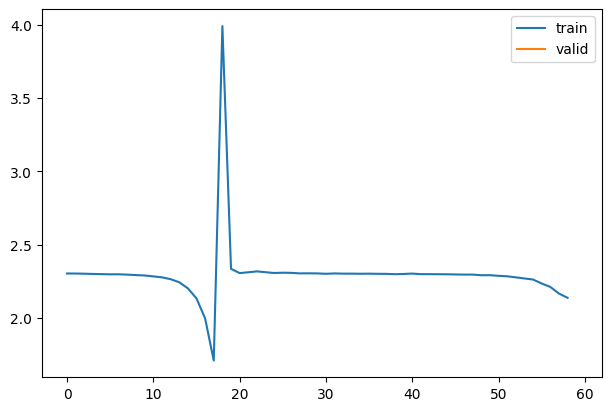

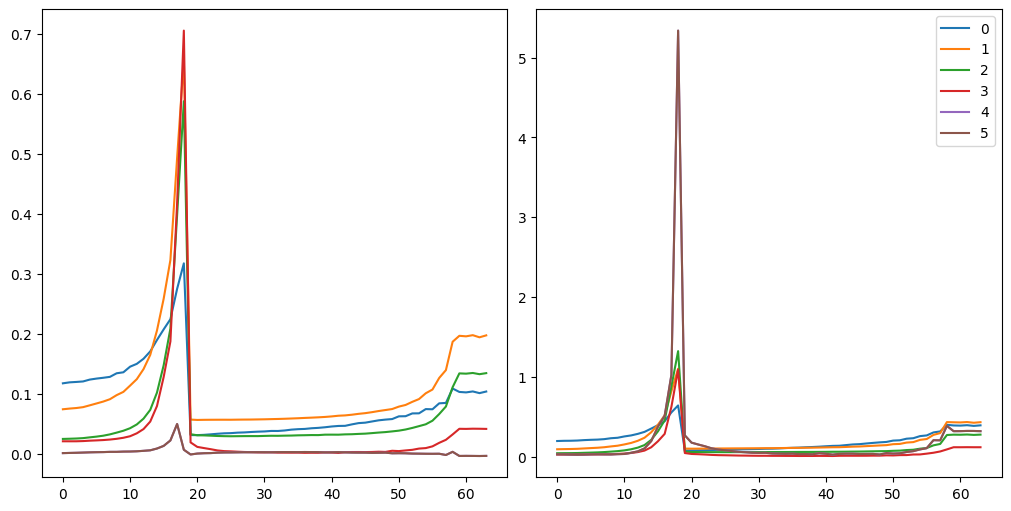

In [34]:
set_seed(1)
md = nn.Sequential(*conv_layers())
with Hooks(md, append_stats) as hooks:
	fit(md)
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	for h in hooks:
		for i in 0,1:
			ax[i].plot(h.stats[i])
	plt.legend(range(len(md)))


#### histogram


In [35]:
#| export
def append_stats(h, mod, inp, out):
	if not hasattr(h, 'stats'):h.stats = ([], [], [])
	act = to_cpu(out)
	h.stats[0].append(act.mean())
	h.stats[1].append(act.std())
	h.stats[2].append(act.histc(40,0, 10))



In [36]:
set_seed(1)
md = nn.Sequential(*conv_layers())

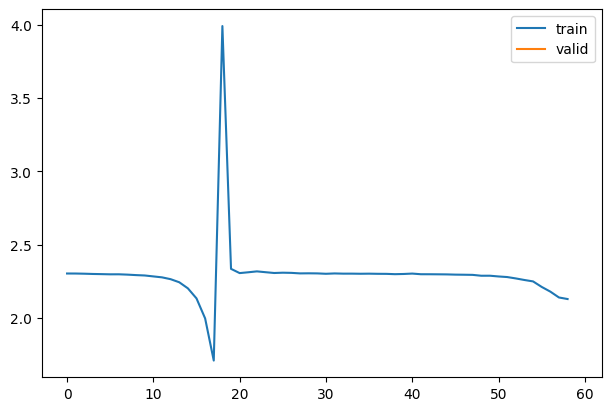

In [37]:
with Hooks(md, append_stats) as hooks:
	fit(md)

In [38]:
#| export
def get_hist(h):return torch.stack(h.stats[2]).t().float().log1p()



In [39]:
delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

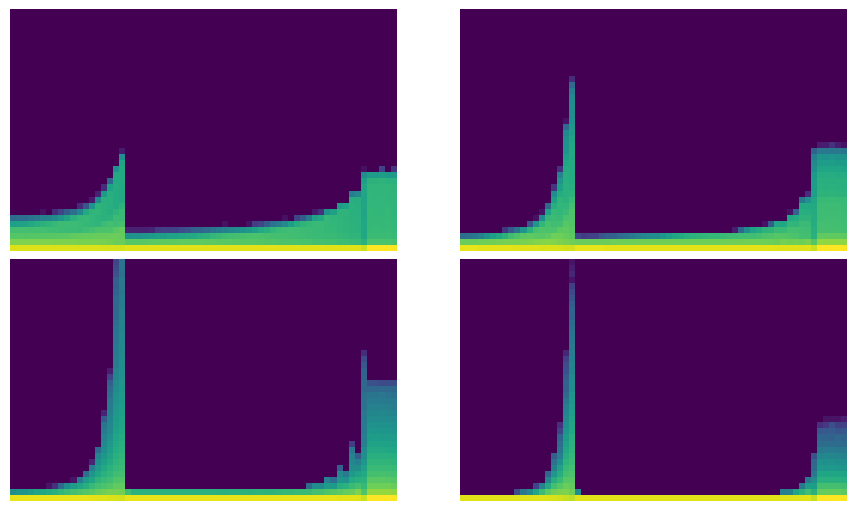

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(9, 5))
for ax, h in zip(axes.flatten(), hooks[:4]):
	show_image(get_hist(h), ax=ax, origin='lower')


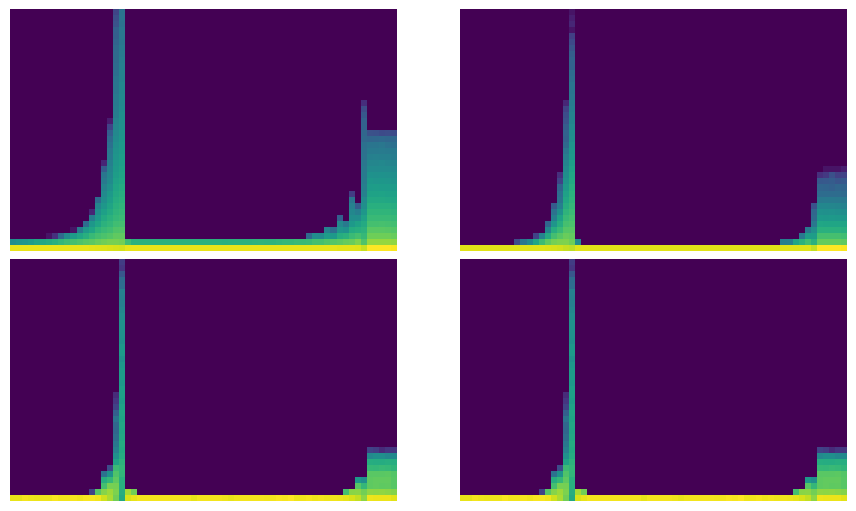

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(9, 5))
for ax, h in zip(axes.flatten(), hooks[-4:]):
	show_image(get_hist(h), ax=ax, origin='lower')

> histogram description [1:17:49]

- Maximum should be like rectangle and each column should be normaly distributed, like nice gradient.
- But here very low very bright means most of them is 0
- During training each layer activation

In [42]:
#| export
def get_min(h):
	h1 = torch.stack(h.stats[2]).t().float().log1p()
	return h1[:2].sum(0)/h1.sum(0)



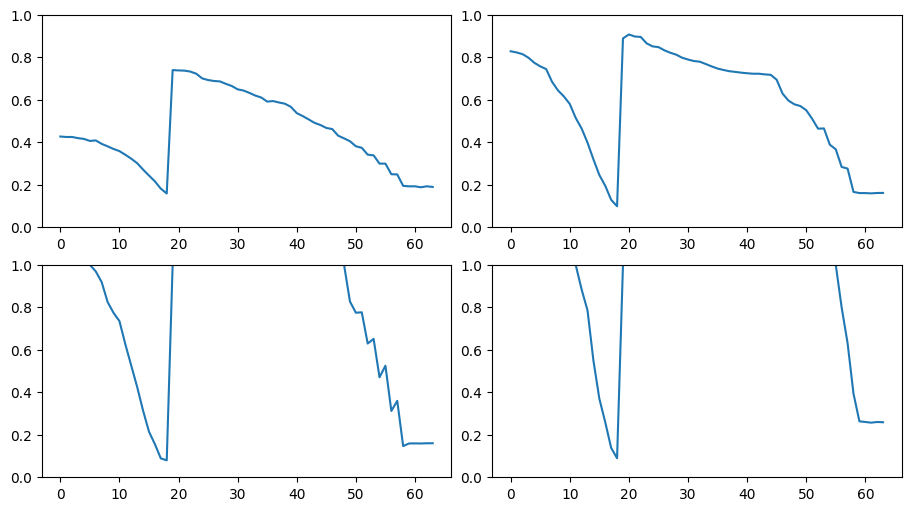

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(9, 5))
for ax, h in zip(axes.flatten(), hooks[:4]):
	ax.plot(get_min(h))
	ax.set_ylim(0, 1)


## Callbacks as Hooks

In [58]:
#| export
class HooksCallback(Callback):
	def __init__(
			self, 
			hookfunc, 
			mod_filter=noop, 
			on_train=True, 
			on_valid=True,
			mods=None):
		store_attr()
		super().__init__()

	def before_fit(self,learn):
		if self.mods: mods = self.mods
		else: mods = filter_ex(
			learn.model.modules(), self.mod_filter)
		self.hooks = Hooks(mods, partial(self._hookfunc, learn))

	def _hookfunc(self, learn,*args, **kwargs):
		if (self.on_train and learn.training) or (self.on_valid and not learn.training): 
			self.hookfunc(*args, **kwargs)

	def after_fit(self, learn):
		self.hooks.remove()

	def __iter__(self):
		return iter(self.hooks)

	def __len__(self):
		return len(self.hooks)


In [54]:
fit?

Signature: fit(model, epochs=1, xtra_cbs=None)
Docstring: <no docstring>
File:      /tmp/ipykernel_406209/3696349075.py
Type:      function

In [55]:
#| export
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(
        model, 
        dls, 
        loss_func=F.cross_entropy, 
        lr=0.6, cbs=cbs+L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.157,2.301,0,train
0.199,2.138,0,eval


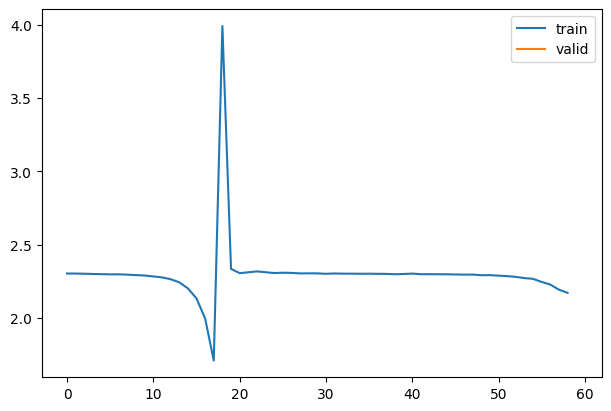

In [59]:
set_seed(1)
md = nn.Sequential(*conv_layers())
hc = HooksCallback(append_stats, mod_filter=risinstance(nn.Conv2d))
fit(md, xtra_cbs=[hc])


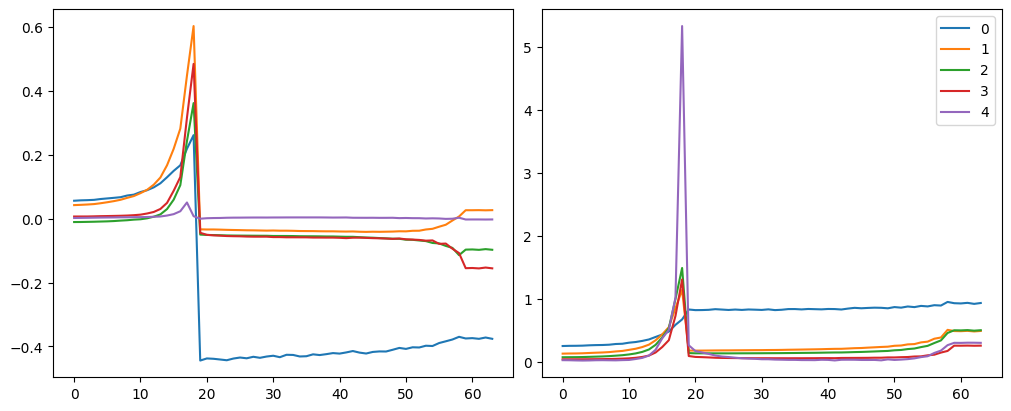

In [60]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

# Activation Stats

In [61]:
#| export
@delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax


In [62]:
#| export
@delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

In [64]:
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(L.range(self))

In [65]:
astats = ActivationStats(risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.156,2.297,0,train
0.302,2.001,0,eval


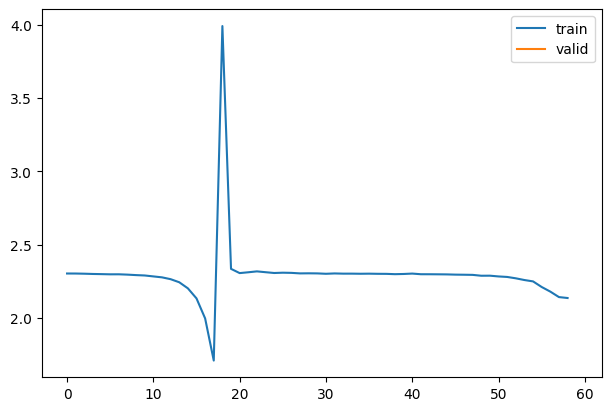

In [66]:
set_seed(1)
model = nn.Sequential(*conv_layers())
fit(model, xtra_cbs=[astats]);

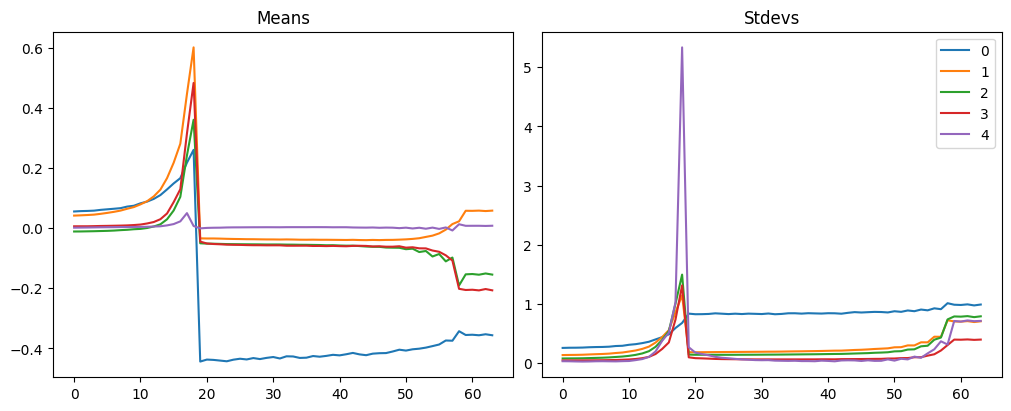

In [67]:
astats.plot_stats()

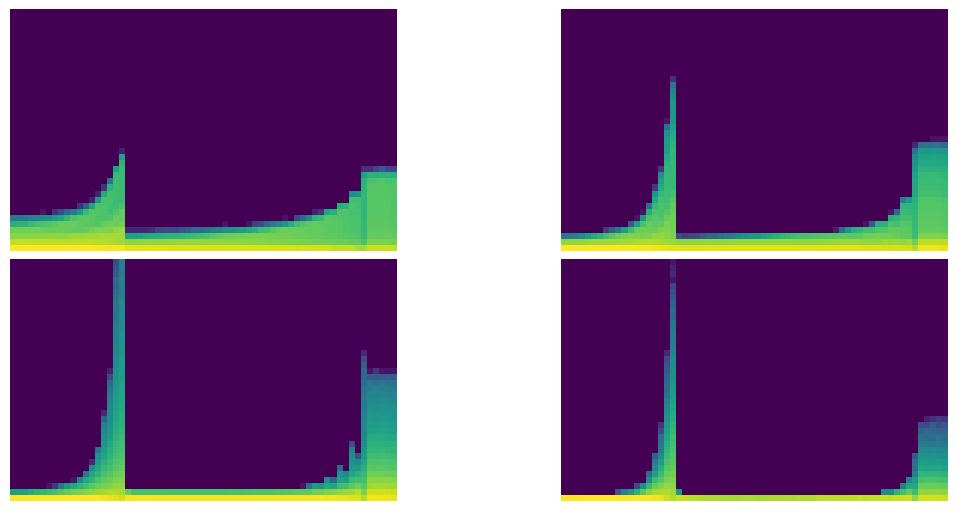

In [68]:
astats.color_dim()

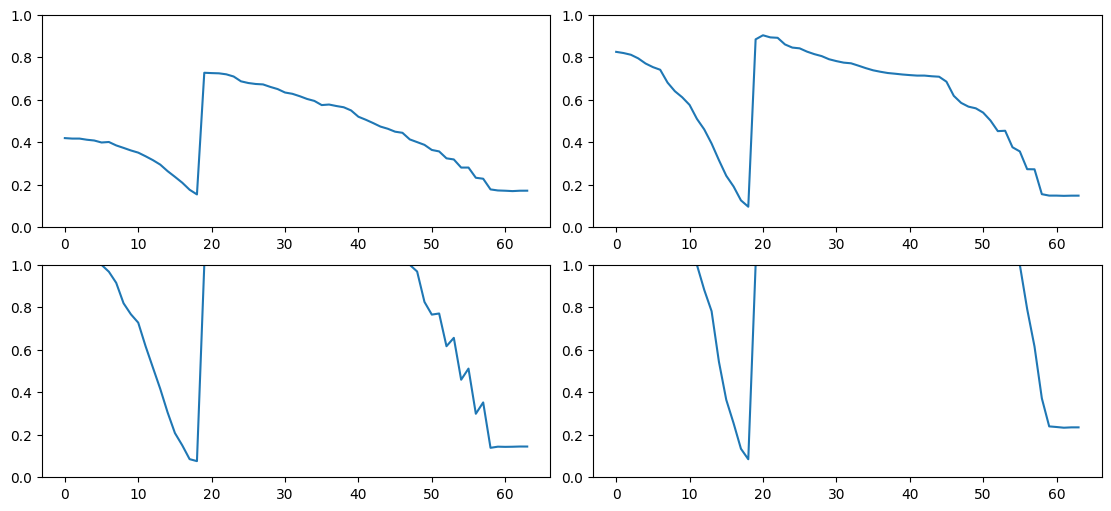

In [69]:
astats.dead_chart()

In [107]:
#| hide
import nbdev; nbdev.nbdev_export('04_preprocessing.lesson_16_second_part.ipynb')